In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# 

In [52]:
df = pd.read_csv("data/spine_dataset.csv")
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


<AxesSubplot:xlabel='Class_att', ylabel='count'>

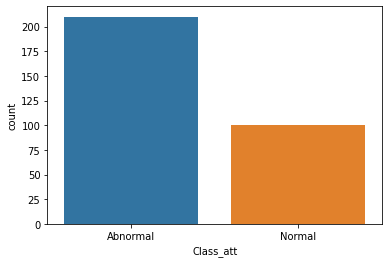

In [53]:
sns.countplot(x = 'Class_att', data=df)

In [54]:
df['Class_att'] = df['Class_att'].astype('category')

encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [55]:
X = df.iloc[:, 0:-2]
y = df.iloc[:, -2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [57]:
y_test


289    0
9      1
57     1
60     1
25     1
      ..
274    0
238    0
97     1
68     1
240    0
Name: Class_att, Length: 103, dtype: int64

In [71]:
EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [59]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))


In [72]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [73]:
train_loader

In [74]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1) #nichuia
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [75]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
print(criterion)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
BCEWithLogitsLoss()


In [77]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    i=0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
#         print(i)
#         i+=1
        
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.01646 | Acc: 99.538
Epoch 002: | Loss: 0.02265 | Acc: 99.077
Epoch 003: | Loss: 0.01174 | Acc: 99.538
Epoch 004: | Loss: 0.03923 | Acc: 98.615
Epoch 005: | Loss: 0.01870 | Acc: 99.538
Epoch 006: | Loss: 0.02480 | Acc: 99.000
Epoch 007: | Loss: 0.01334 | Acc: 100.000
Epoch 008: | Loss: 0.00786 | Acc: 100.000
Epoch 009: | Loss: 0.01352 | Acc: 99.538
Epoch 010: | Loss: 0.00740 | Acc: 100.000
Epoch 011: | Loss: 0.00745 | Acc: 100.000
Epoch 012: | Loss: 0.00507 | Acc: 100.000
Epoch 013: | Loss: 0.02611 | Acc: 99.538
Epoch 014: | Loss: 0.00516 | Acc: 100.000
Epoch 015: | Loss: 0.04774 | Acc: 98.000
Epoch 016: | Loss: 0.00898 | Acc: 100.000
Epoch 017: | Loss: 0.02443 | Acc: 99.077
Epoch 018: | Loss: 0.03983 | Acc: 98.154
Epoch 019: | Loss: 0.00838 | Acc: 100.000
Epoch 020: | Loss: 0.04314 | Acc: 99.538
Epoch 021: | Loss: 0.00627 | Acc: 100.000
Epoch 022: | Loss: 0.00663 | Acc: 100.000
Epoch 023: | Loss: 0.00406 | Acc: 100.000
Epoch 024: | Loss: 0.00239 | Acc: 100.000
Epoc

In [78]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
confusion_matrix(y_test, y_pred_list)

array([[23,  6],
       [13, 61]])

In [79]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.64      0.79      0.71        29
           1       0.91      0.82      0.87        74

    accuracy                           0.82       103
   macro avg       0.77      0.81      0.79       103
weighted avg       0.83      0.82      0.82       103

